In [1]:
from sklearn.datasets.samples_generator import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std

C:\Anaconda3\envs\nlpiaenv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2,random_state=seed)

    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

In [3]:
# define and fit model on a training dataset
def fit_model(trainX, trainy):
    
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)
    return model

In [4]:
# repeated evaluation of a standalone model
def eval_standalone_model(trainX, trainy, testX, testy, n_repeats):
    
    scores = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        model = fit_model(trainX, trainy)
        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    return scores

In [5]:
# repeated evaluation of a model with transfer learning
def eval_transfer_model(trainX, trainy, testX, testy, n_fixed, n_repeats):
    
    scores = list()
    for _ in range(n_repeats):
        
        # load model
        model = load_model('model.h5')

        # mark layer weights as fixed or not trainable
        for i in range(n_fixed):
            model.layers[i].trainable = False

        # re-compile model
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # fit model on train dataset
        model.fit(trainX, trainy, epochs=100, verbose=0)

        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    return scores

In [6]:
# prepare data for problem 2
trainX, trainy, testX, testy = samples_for_seed(2)

In [7]:
n_repeats = 30
dists, dist_labels = list(), list()

In [8]:
# repeated evaluation of standalone model
standalone_scores = eval_standalone_model(trainX, trainy, testX, testy, n_repeats)
print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))


Standalone 0.804 (0.062)


In [9]:
dists.append(standalone_scores)
dist_labels.append('standalone')

In [10]:
# repeated evaluation of transfer learning model, vary fixed layers

In [11]:
n_fixed = 3
for i in range(n_fixed):
    scores = eval_transfer_model(trainX, trainy, testX, testy, i, n_repeats)
    print('Transfer (fixed=%d) %.3f (%.3f)' % (i, mean(scores), std(scores)))
    dists.append(scores)
    dist_labels.append('transfer f='+str(i))

Transfer (fixed=0) 0.795 (0.005)
Transfer (fixed=1) 0.790 (0.003)
Transfer (fixed=2) 0.777 (0.007)


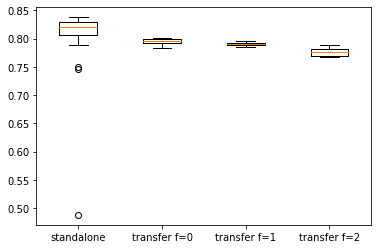

In [12]:
# box and whisker plot of score distributions
pyplot.boxplot(dists, labels=dist_labels)
pyplot.show()

In [ ]:
# we see that the behavior of the models with transfer learning are more stable, showing a tighter
# distribution in performance.